In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import transforms
import itertools
import importlib
import time
import math
from training.util import plot_losses, adam, sgd

c:\Users\flose\anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from training import toy
importlib.reload(toy)
torch.manual_seed(42)

batch_size = 2

trainset = toy.TwoMoonsDataset(samples=200, noise=0.15, seed=13)
trainloader = torch.utils.data.DataLoader(trainset.dataset(), batch_size, shuffle=True)

testset = toy.TwoMoonsDataset(samples=200, noise=0.15, seed=0)

device = torch.device("cpu")

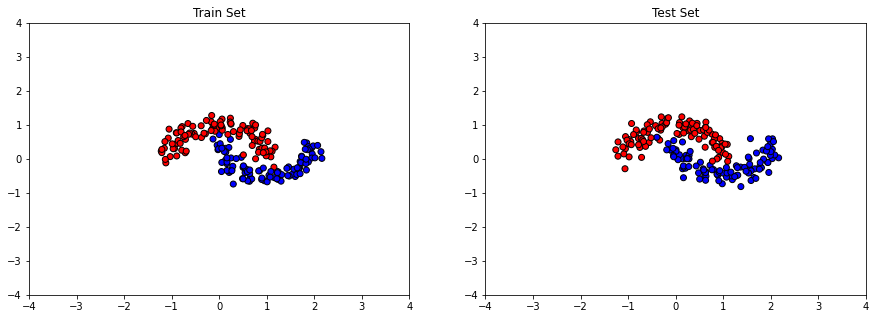

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

eval_points = 100
sample_cmap = ListedColormap(["red", "blue"])
area_cmap = plt.cm.RdBu
variance_cmap = plt.cm.viridis
xlim = 4
ylim = 4

def plot_samples(ax, dataset):
    ax.scatter(dataset.samples[:,0], dataset.samples[:,1], c=dataset.labels, cmap=sample_cmap, edgecolors="black")

def plot(name, eval, samples, show_data=True, include_caption=True):
    with torch.no_grad():
        fig, value_ax = plt.subplots(1, 1)
        if include_caption:
            fig.suptitle(name)
        value_ax.set_xlim(-xlim, xlim)
        value_ax.set_ylim(-ylim, ylim)
        value_ax.set_axis_off()
        
        # Grid evaluation
        xs, ys = np.meshgrid(np.linspace(-xlim, xlim, eval_points), np.linspace(-ylim, ylim, eval_points))
        data = np.dstack((xs.reshape(eval_points * eval_points), ys.reshape(eval_points * eval_points)))[0]
        with torch.no_grad():
            results = eval(torch.from_numpy(data).float(), samples).reshape((samples, eval_points, eval_points))
        value_ax.contourf(xs, ys, results.mean(dim=0), 100, cmap=area_cmap)

        # Training samples
        with torch.no_grad():
            results = eval(testset.samples, samples)
        predictions = torch.round(results.mean(dim=0))
        corrects = (predictions == testset.labels).sum()
        print(f"Test accuracy {corrects} / {len(predictions)} ({(corrects / len(predictions)):.3f})")
        if show_data:
            value_ax.scatter(*zip(*testset.samples), facecolors=sample_cmap(predictions), edgecolors=sample_cmap(testset.labels))

        fig.tight_layout(pad=0)
        return fig

fig, (train_fig, test_fig) = plt.subplots(1, 2, figsize=(15, 5))
train_fig.set_title("Train Set")
train_fig.set_xlim(-xlim, xlim)
train_fig.set_ylim(-ylim, ylim)
test_fig.set_title("Test Set")
test_fig.set_xlim(-xlim, xlim)
test_fig.set_ylim(-ylim, ylim)
plot_samples(train_fig, trainset)
plot_samples(test_fig, testset)

Final loss 0.026620278134942055
Test accuracy 198 / 200 (0.990)


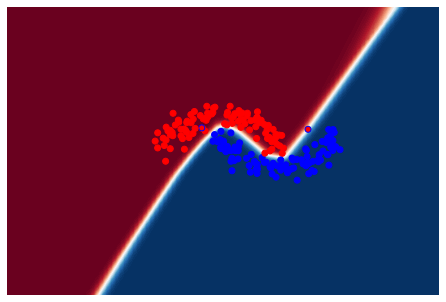

In [5]:
from training.pp import MAP
torch.manual_seed(42)

layers = [
    ("fc", (2, 16)),
    ("relu", ()),
    ("fc", (16, 16)),
    ("relu", ()),
    ("fc", (16, 1)),
    ("sigmoid", ())
]
pp = MAP(layers)
pp.train_model(50, nn.BCELoss(), sgd(lr=0.05), trainloader, batch_size, device, report_every_epochs=0)

plot("MAP", pp.infer, 1000, include_caption=False).savefig("results/toy/classification/map.pdf")

Final loss 0.025431158021092415
SWAG: Collected 30 out of 30 deviation samples and 30 parameter samples
Test accuracy 199 / 200 (0.995)


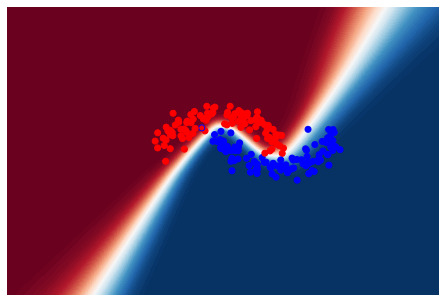

In [9]:
from training.swag import SwagModel
torch.manual_seed(42)

layers = [
    ("fc", (2, 16)),
    ("relu", ()),
    ("fc", (16, 16)),
    ("relu", ()),
    ("fc", (16, 1)),
    ("sigmoid", ())
]
swag_config = {
    "start_epoch": 40,
    "update_every_batches": len(trainloader),
    "deviation_samples": 30
}
swag = SwagModel(layers, swag_config)
swag.train_model(70, nn.BCELoss(), sgd(lr=0.05), trainloader, batch_size, device, report_every_epochs=0)

plot("SWAG", swag.infer, 1000, include_caption=False).savefig("results/toy/classification/swag.pdf")

Training ensemble member 0
Final loss 0.03140968829393387
Training ensemble member 1
Final loss 0.026941070333123207
Training ensemble member 2
Final loss 0.02536292001605034
Training ensemble member 3
Final loss 0.021316688507795334
Training ensemble member 4
Final loss 0.02255288138985634
Test accuracy 197 / 200 (0.985)


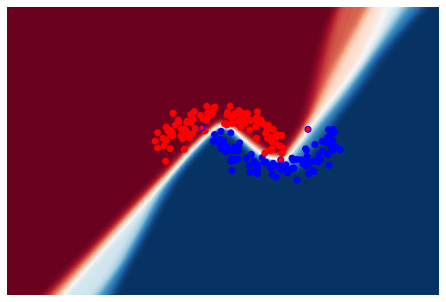

In [6]:
from training.ensemble import Ensemble
torch.manual_seed(42)

layers = [
    ("fc", (2, 16)),
    ("relu", ()),
    ("fc", (16, 16)),
    ("relu", ()),
    ("fc", (16, 1)),
    ("sigmoid", ())
]
ensemble = Ensemble([MAP(layers) for _ in range(5)])
ensemble.train_model(50, nn.BCELoss(), sgd(0.05), trainloader, batch_size, device, report_every_epochs=0)

plot("Ensemble-5", ensemble.infer, 5, include_caption=False).savefig("results/toy/classification/ensemble.pdf")

Training ensemble member 0
Final loss 0.08266587555408478
Training ensemble member 1
Final loss 0.1023150086402893
Training ensemble member 2
Final loss 0.10803171247243881
Training ensemble member 3
Final loss 0.07966878265142441
Training ensemble member 4
Final loss 0.10452686250209808
Training ensemble member 5
Final loss 0.05723006650805473
Training ensemble member 6
Final loss 0.06017327681183815
Training ensemble member 7
Final loss 0.07802576571702957
Training ensemble member 8
Final loss 0.11719129234552383
Training ensemble member 9
Final loss 0.07329829037189484
Test accuracy 196 / 200 (0.980)


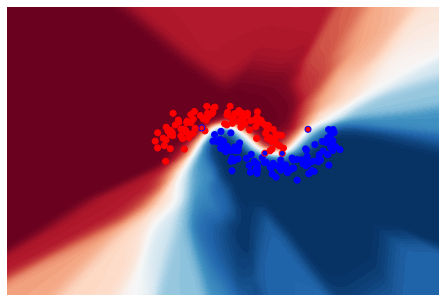

In [5]:
from training.ensemble import Ensemble
from training.rms import RMSModule
torch.manual_seed(42)

layers = [
    ("fc", (2, 16)),
    ("relu", ()),
    ("fc", (16, 16)),
    ("relu", ()),
    ("fc", (16, 1)),
    ("sigmoid", ())
]
rms = Ensemble([RMSModule(layers, 1.0, 1/np.sqrt(2), 0.05) for _ in range(10)])
rms.train_model(50, nn.BCELoss(), sgd(0.05), trainloader, batch_size, device, report_every_epochs=0)

plot("RMS-5", rms.infer, 1000, include_caption=False).savefig("results/toy/classification/rms.pdf")

Final loss 0.050497397780418396
Test accuracy 197 / 200 (0.985)


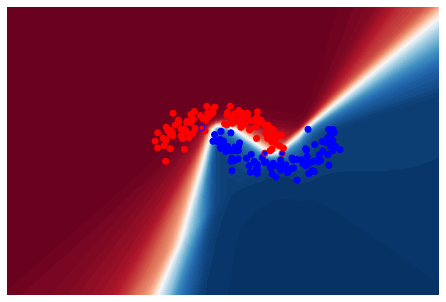

In [7]:
torch.manual_seed(42)

layers = [
    ("fc", (2, 16)),
    ("dropout", (0.2,)),
    ("relu", ()),
    ("fc", (16, 16)),
    ("dropout", (0.2,)),
    ("relu", ()),
    ("fc", (16, 1)),
    ("sigmoid", ())
]
mc_dropout = MAP(layers)
mc_dropout.train_model(70, nn.BCELoss(), sgd(0.05), trainloader, batch_size, device, report_every_epochs=0)

plot("MC Dropout", mc_dropout.infer, 1000, include_caption=False).savefig("results/toy/classification/mc_dropout.pdf")

Final loss 0.172206312417984
Test accuracy 198 / 200 (0.990)


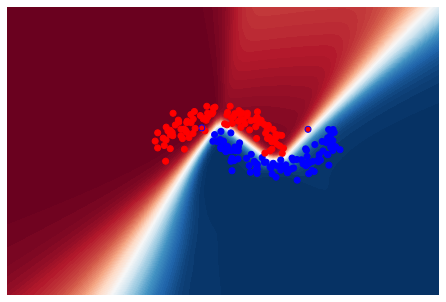

In [31]:
from training.bbb import BBBModel, GaussianPrior
torch.manual_seed(42)

bbb_prior = GaussianPrior(0, 1)
layers = [
    ("v_fc", (2, 16, bbb_prior, {"rho_init": -3})),
    ("relu", ()),
    ("v_fc", (16, 16, bbb_prior, {"rho_init": -3})),
    ("relu", ()),
    ("v_fc", (16, 1, bbb_prior, {"rho_init": -3})),
    ("sigmoid", ())
]
bbb = BBBModel(layers)
bbb.train_model(200, nn.BCELoss(), sgd(lr=0.1), trainloader, batch_size, device, kl_rescaling=0.5, mc_samples=2, report_every_epochs=0)

plot("Bayes By Backprop", bbb.infer, 1000, include_caption=False).savefig("results/toy/classification/bbb_0_5.pdf")

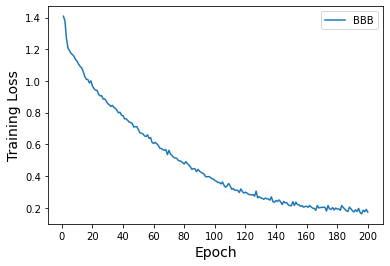

In [32]:
plot_losses("BBB", bbb.all_losses(), plt.subplot())

Final loss 0.2017347365617752
Test accuracy 197 / 200 (0.985)


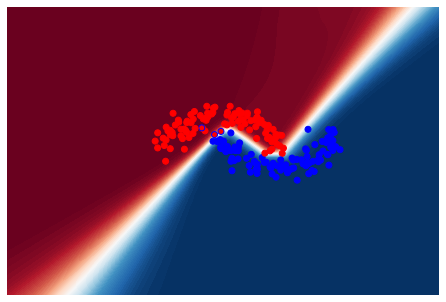

In [43]:
from training.bbb import BBBModel, GaussianPrior
torch.manual_seed(42)

layers = [
    ("vlr_fc", (2, 16, 2, 1, {"rho_init": -3})),
    ("relu", ()),
    ("vlr_fc", (16, 16, 2, 1, {"rho_init": -3})),
    ("relu", ()),
    ("vlr_fc", (16, 1, 2, 1, {"rho_init": -3})),
    ("sigmoid", ())
]
bbb_lr2 = BBBModel(layers)
bbb_lr2.train_model(200, nn.BCELoss(), sgd(lr=0.1), trainloader, batch_size, device, kl_rescaling=0.5, mc_samples=2, report_every_epochs=0)

plot("Bayes By Backprop (LR-2)", bbb_lr2.infer, 1000, include_caption=False).savefig("results/toy/classification/bbb_lr2_0_5.pdf")

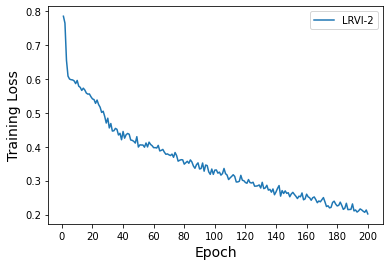

In [44]:
plot_losses("LRVI-2", bbb_lr2.all_losses(), plt.subplot())

Final loss 0.12936793267726898
Test accuracy 197 / 200 (0.985)


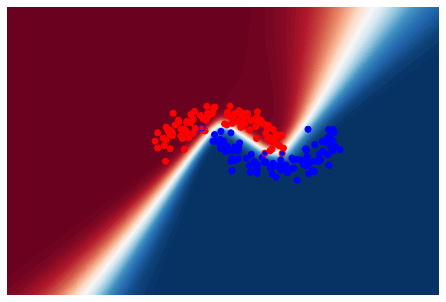

In [45]:
from training.bbb import BBBModel, GaussianPrior
torch.manual_seed(42)

layers = [
    ("vlr_fc", (2, 16, 10, 1, {"rho_init": -3})),
    ("relu", ()),
    ("vlr_fc", (16, 16, 10, 1, {"rho_init": -3})),
    ("relu", ()),
    ("vlr_fc", (16, 1, 10, 1, {"rho_init": -3})),
    ("sigmoid", ())
]
bbb_lr10 = BBBModel(layers)
bbb_lr10.train_model(300, nn.BCELoss(), sgd(lr=0.1), trainloader, batch_size, device, kl_rescaling=0.5, mc_samples=2, report_every_epochs=0)

plot("Bayes By Backprop (LR-10)", bbb_lr10.infer, 1000, include_caption=False).savefig("results/toy/classification/bbb_lr10_0_5.pdf")

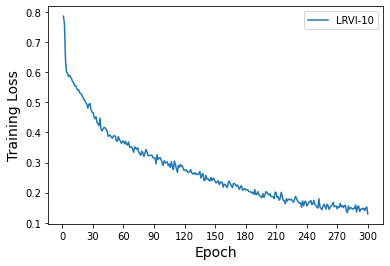

In [46]:
plot_losses("LRVI-10", bbb_lr10.all_losses(), plt.subplot())

Epoch 0: loss 59.383052825927734
SGLD: Burnin completed in epoch 100; now collecting posterior samples
Epoch 100: loss 5.182713031768799
Epoch 200: loss 9.827654838562012
Epoch 300: loss 60.645660400390625
Epoch 400: loss 4.075326442718506
Epoch 500: loss 7.417172431945801
Epoch 600: loss 8.034939765930176
Epoch 700: loss 7.36868953704834
Epoch 800: loss 2.3281092643737793
Epoch 900: loss 5.839895725250244
Epoch 1000: loss 29.091224670410156
Epoch 1100: loss 156.2560577392578
Epoch 1200: loss 26.757780075073242
Epoch 1300: loss 65.9107437133789
Epoch 1400: loss 54.31950378417969
Epoch 1500: loss 16.37335968017578
Epoch 1600: loss 55.4428825378418
Epoch 1700: loss 7.6377668380737305
Epoch 1800: loss 57.6673469543457
Epoch 1900: loss 58.493526458740234
Epoch 2000: loss 56.530574798583984
Epoch 2100: loss 107.1506118774414
Epoch 2200: loss 57.58895492553711
Epoch 2300: loss 4.558481216430664
Epoch 2400: loss 58.264678955078125
Epoch 2500: loss 7.470785140991211
Epoch 2600: loss 145.577743

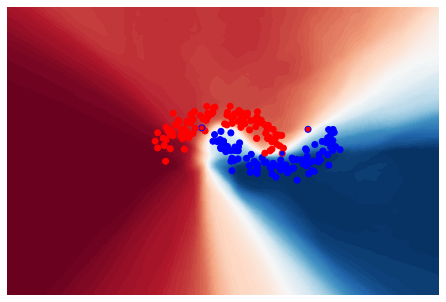

In [20]:
from training.sgld import SGLDModule, sgld
torch.manual_seed(42)

layers = [
    ("fc", (2, 16)),
    ("relu", ()),
    ("fc", (16, 16)),
    ("relu", ()),
    ("fc", (16, 1)),
    ("sigmoid", ())
]
mcmc = SGLDModule(layers, 100, 10)
mcmc.train_model(10100, nn.BCELoss(), sgld(lr=2e-4), trainloader, batch_size, device, report_every_epochs=100)

plot("SGLD", mcmc.infer, 1000, include_caption=False).savefig("results/toy/classification/sgld.pdf")